In [1]:
# Thu Vien
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import statistics
from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances


c:\Users\USER\.conda\envs\recommenders-env\lib\site-packages\pandera\_pandas_deprecated.py:157: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


In [2]:
# Đọc dữ liệu
df = movielens.load_pandas_df(size="100k", header=["userId", "movieId", "rating", "timestamp"])
df = df[["userId", "movieId", "rating"]]

100%|██████████| 4.81k/4.81k [00:12<00:00, 371KB/s]  


In [ ]:
# chuyển dữ liệu từ dạng bảng sang dạng ma trận người dùng – sản phẩm
user_item_matrix = df.pivot(index="userId", columns="movieId", values="rating")
user_item_filled = SimpleImputer(strategy="constant", fill_value=0).fit_transform(user_item_matrix)

In [15]:
# Chuẩn hóa dữ liệu
user_standard = StandardScaler().fit_transform(user_item_filled)
user_standard_df = pd.DataFrame(user_standard, index=user_item_matrix.index, columns=user_item_matrix.columns)
print(user_standard_df.iloc[:5, :5])

movieId         1         2         3        4         5
userId                                                  
1        1.538970  2.191881  3.841096  1.43463  2.719871
2        1.049014 -0.382146 -0.299691 -0.51006 -0.303514
3       -0.910808 -0.382146 -0.299691 -0.51006 -0.303514
4       -0.910808 -0.382146 -0.299691 -0.51006 -0.303514
5        1.049014  2.191881 -0.299691 -0.51006 -0.303514


In [14]:
# Tính khoảng cách
user_distances = euclidean_distances(user_standard)
user_distance_df = pd.DataFrame(user_distances, index=user_item_matrix.index, columns=user_item_matrix.index)
print(user_distance_df.iloc[:5, :5])


userId          1          2          3          4          5
userId                                                       
1        0.000000  70.506488  70.171895  71.185803  78.126685
2       70.506488   0.000000  37.174930  39.208020  61.540997
3       70.171895  37.174930   0.000000  33.397737  59.775691
4       71.185803  39.208020  33.397737   0.000000  61.025586
5       78.126685  61.540997  59.775691  61.025586   0.000000


In [6]:
# Chia tập train/test
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

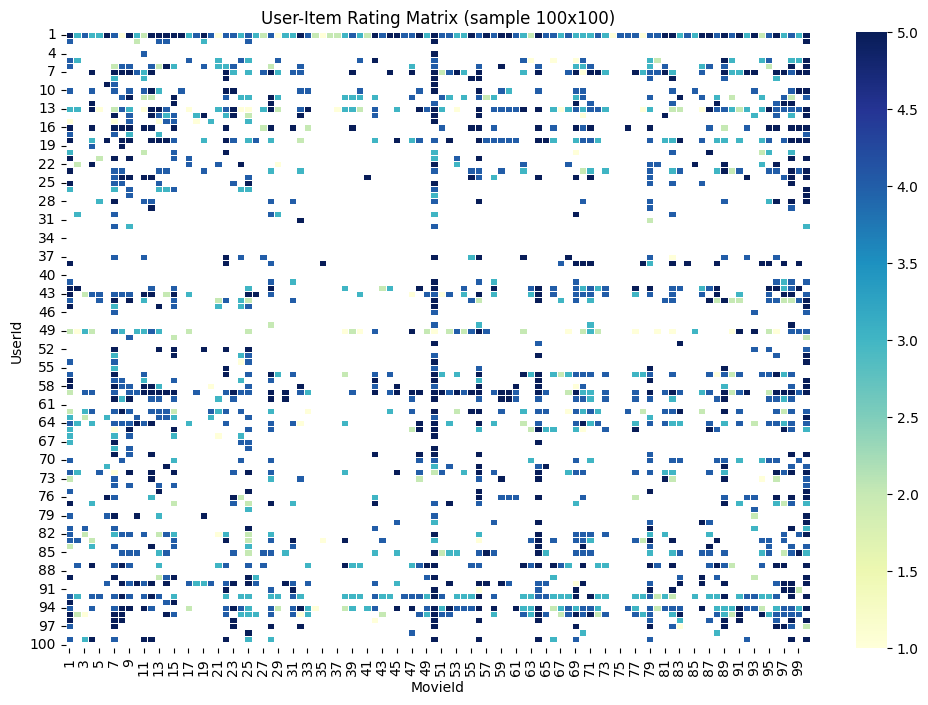

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# user_item_matrix (userId × movieId)
subset_matrix = user_item_matrix.iloc[:100, :100]  # lấy 100 người × 100 phim 

plt.figure(figsize=(12, 8))
sns.heatmap(subset_matrix, cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.xlabel("MovieId")
plt.ylabel("UserId")
plt.title("User-Item Rating Matrix (sample 100x100)")
plt.show()


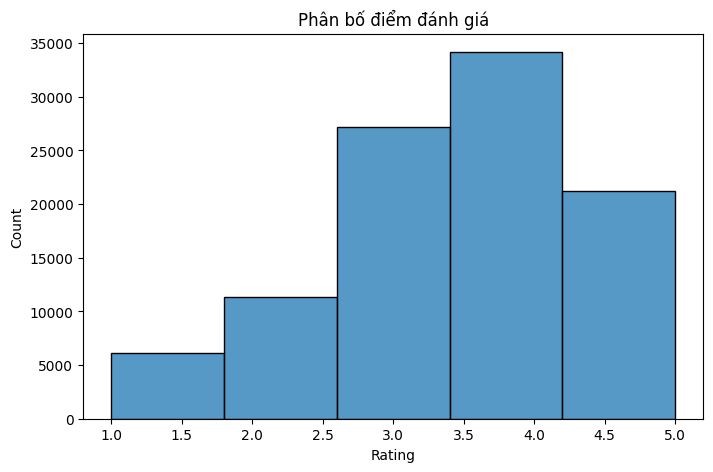

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Vẽ phân bố điểm đánh giá
plt.figure(figsize=(8, 5))
sns.histplot(df['rating'], bins=5, kde=False)  # bins=5 vì rating 1-5
plt.title("Phân bố điểm đánh giá")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


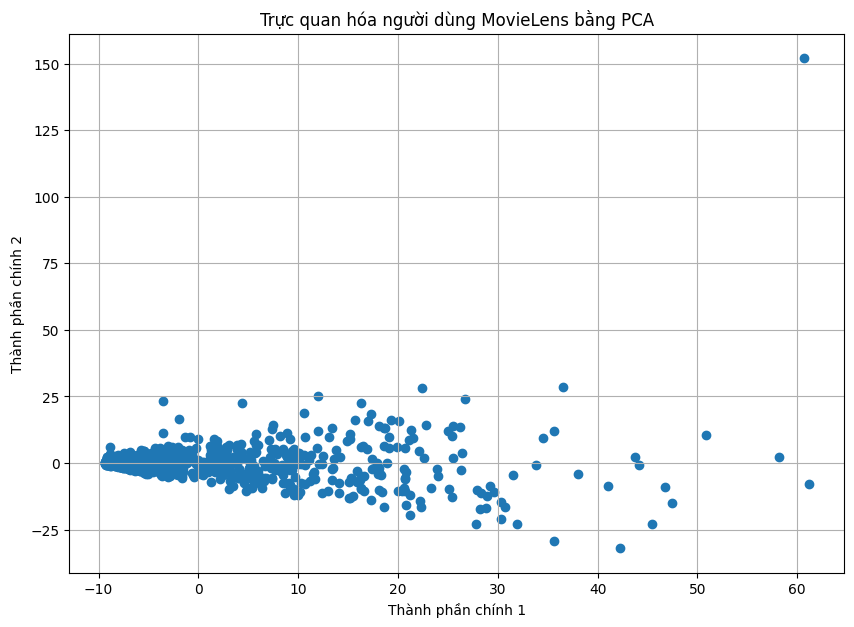

In [5]:
from sklearn.decomposition import PCA

# user_standard: chuẩn hóa ma trận người dùng - phim (đã chuẩn hóa bằng StandardScaler)
pca = PCA(n_components=2)
user_2d = pca.fit_transform(user_standard)

# Vẽ scatterplot
plt.figure(figsize=(10, 7))
plt.scatter(user_2d[:, 0], user_2d[:, 1])
plt.title("Trực quan hóa người dùng MovieLens bằng PCA")
plt.xlabel("Thành phần chính 1")
plt.ylabel("Thành phần chính 2")
plt.grid(True)
plt.show()


In [ ]:
def predict_rating(user_id, movie_id, k):
    # Kiểm tra xem userId và movieId có tồn tại trong ma trận không
    if movie_id not in user_item_matrix.columns or user_id not in user_item_matrix.index:
        return np.nan

    if user_id not in user_distance_df.index:
        return np.nan

    # Lấy khoảng cách từ user hiện tại tới tất cả user khác
    distances = user_distance_df.loc[user_id] #lấy ra một hàng tương ứng với user đó
    distances = distances.drop(user_id, errors="ignore")  # Bỏ chính nó nếu có

    if distances.empty:
        return np.nan

    # Lấy k user gần nhất
    nearest_users = distances.nsmallest(k).index

    # Lấy rating của các user này với movie hiện tại
    neighbor_ratings = user_item_matrix.loc[nearest_users, movie_id]

    # Loại bỏ các giá trị NaN
    valid_ratings = neighbor_ratings.dropna()
    if valid_ratings.empty:
        return np.nan

    # Trả về trung bình rating
    return valid_ratings.mean()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

sample_test = test_data

test_subset = sample_test.copy()
test_subset["predicted_rating"] = test_subset.apply(
    lambda row: predict_rating(row["userId"], row["movieId"], k=5), axis=1
)

test_subset = test_subset.dropna(subset=["predicted_rating"])

y_true = test_subset["rating"]
y_pred = test_subset["predicted_rating"]

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE = {rmse:.4f} | MAE = {mae:.4f} | MSE = {mse:.4f}")

RMSE = 1.2243 | MAE = 0.9412 | MSE = 1.4989


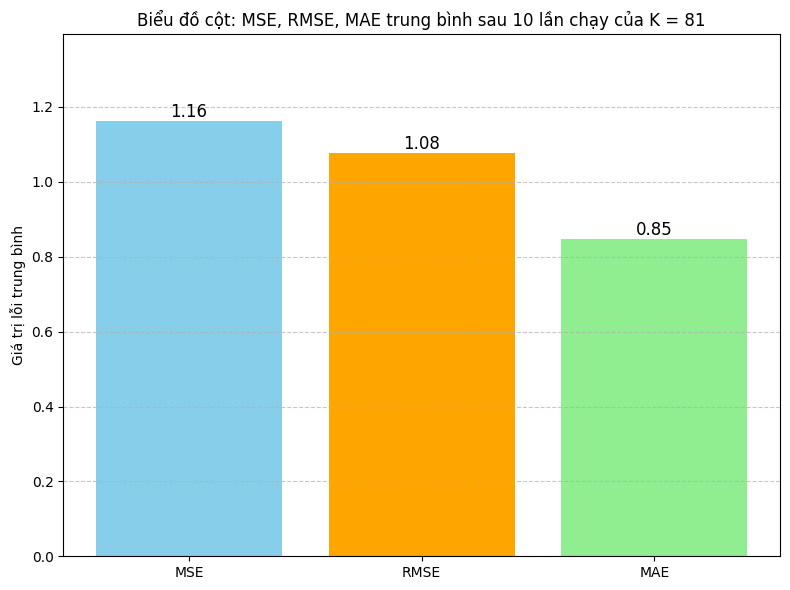

K=81:
Avg Train Time: 1.9863s
Avg Test Time: 0.0001s
Trung binh: RMSE = 1.0773 | MAE = 0.8477 | MSE = 1.1615


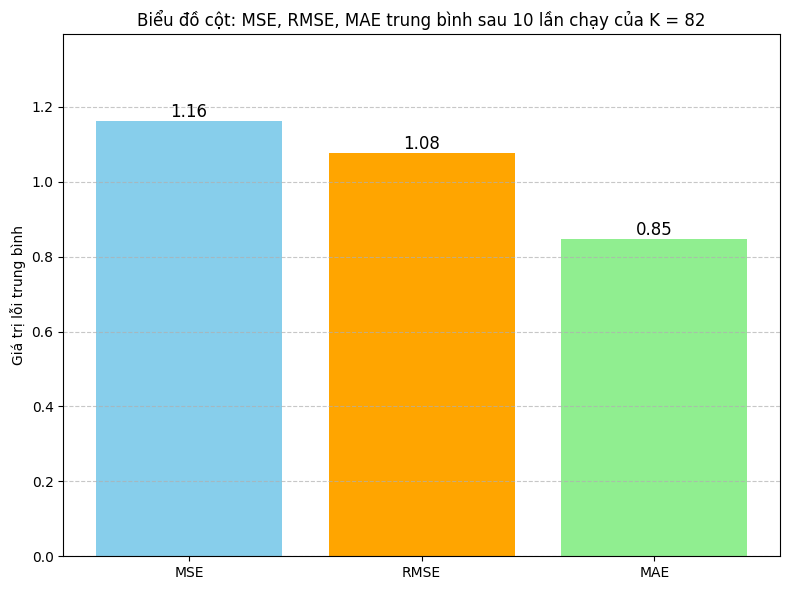

K=82:
Avg Train Time: 2.7926s
Avg Test Time: 0.0000s
Trung binh: RMSE = 1.0772 | MAE = 0.8476 | MSE = 1.1613


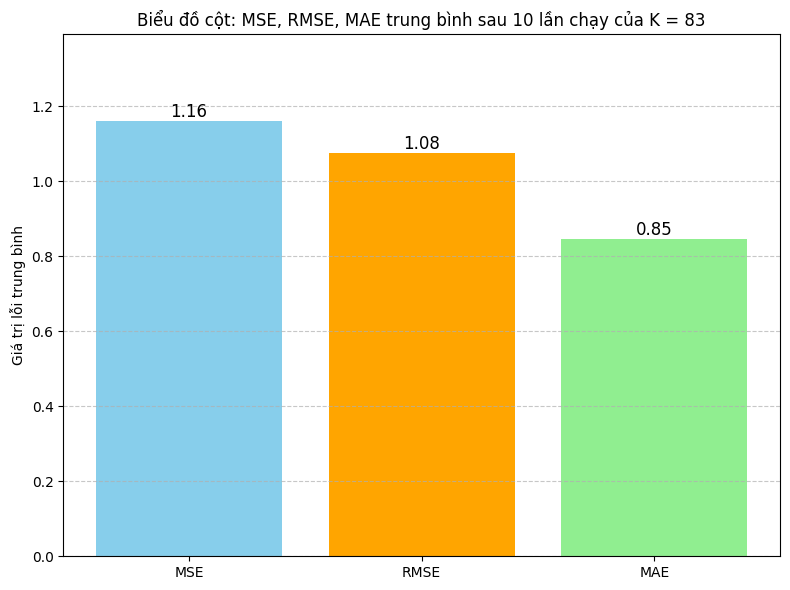

K=83:
Avg Train Time: 1.0582s
Avg Test Time: 0.0001s
Trung binh: RMSE = 1.0764 | MAE = 0.8470 | MSE = 1.1596


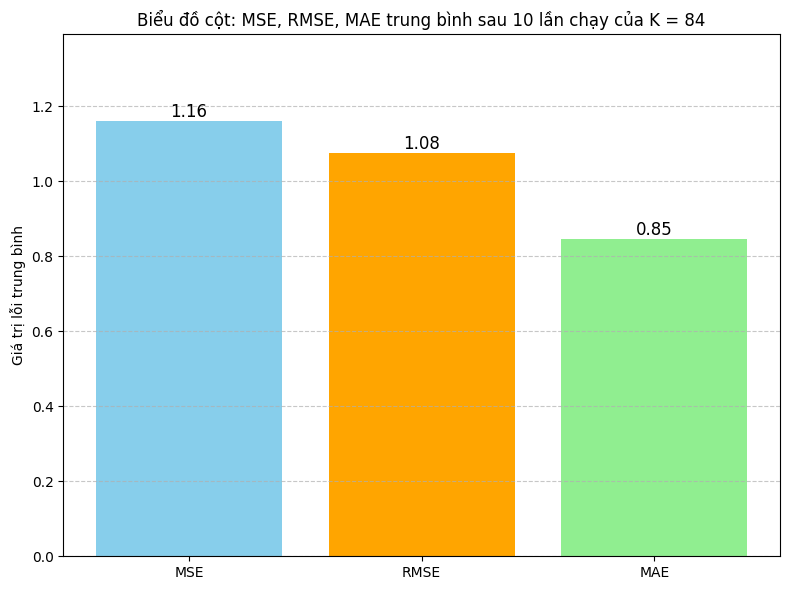

K=84:
Avg Train Time: 1.8612s
Avg Test Time: 0.0000s
Trung binh: RMSE = 1.0765 | MAE = 0.8469 | MSE = 1.1599


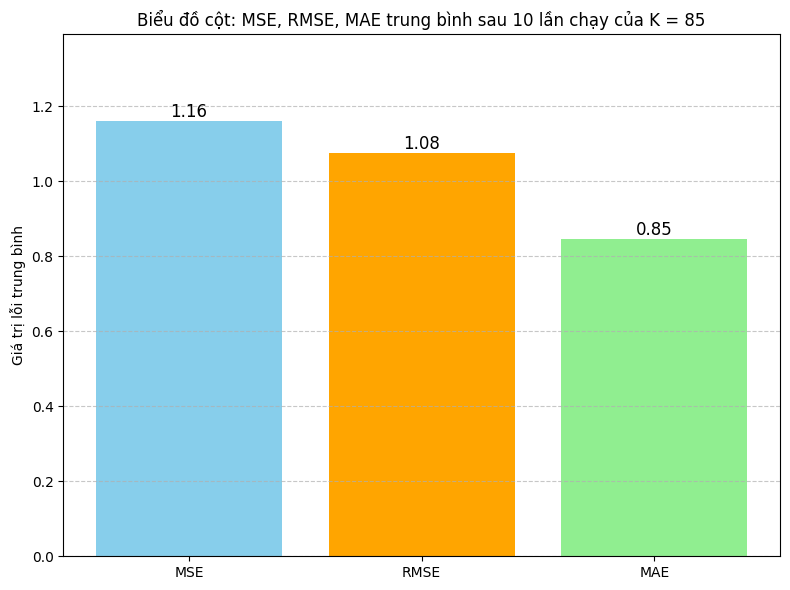

K=85:
Avg Train Time: 2.6893s
Avg Test Time: 0.0000s
Trung binh: RMSE = 1.0764 | MAE = 0.8463 | MSE = 1.1596


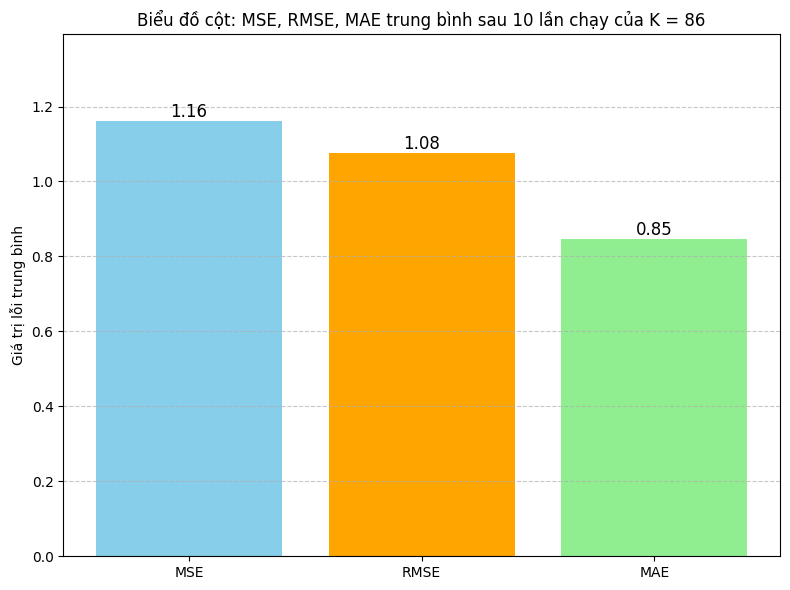

K=86:
Avg Train Time: 1.5829s
Avg Test Time: 0.0000s
Trung binh: RMSE = 1.0767 | MAE = 0.8469 | MSE = 1.1603


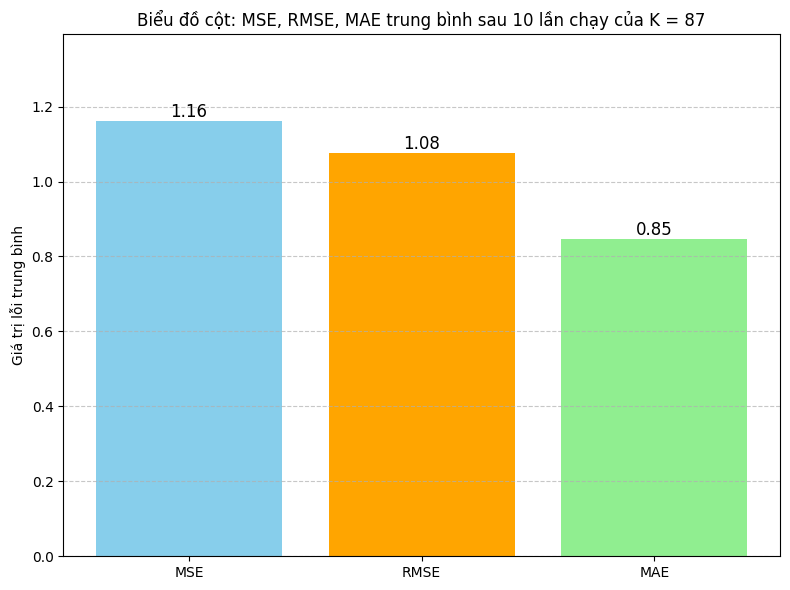

K=87:
Avg Train Time: 1.3030s
Avg Test Time: 0.0000s
Trung binh: RMSE = 1.0768 | MAE = 0.8474 | MSE = 1.1605


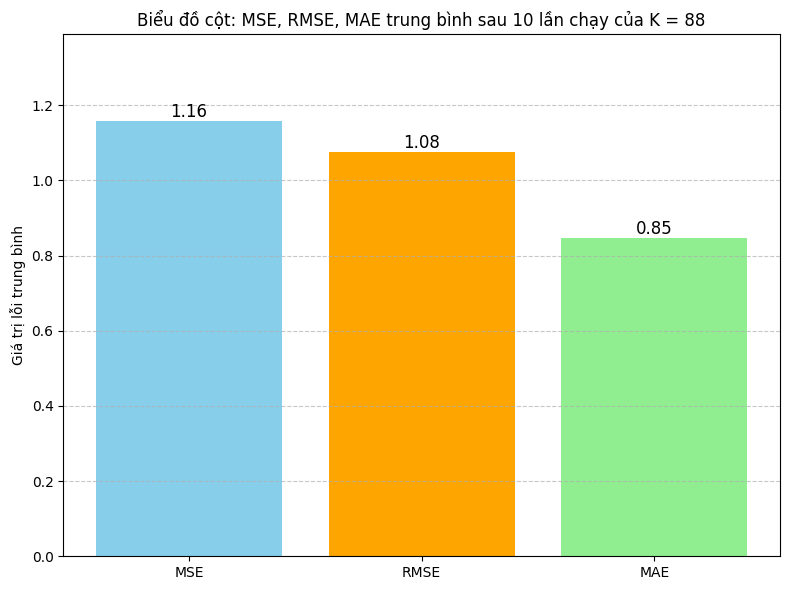

K=88:
Avg Train Time: 3.9060s
Avg Test Time: 0.0000s
Trung binh: RMSE = 1.0751 | MAE = 0.8464 | MSE = 1.1568


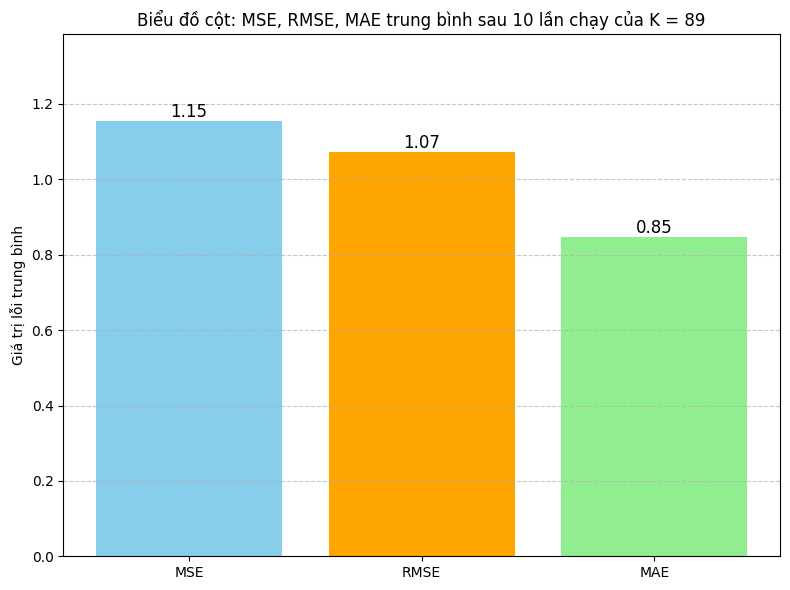

K=89:
Avg Train Time: 2.8831s
Avg Test Time: 0.0001s
Trung binh: RMSE = 1.0737 | MAE = 0.8460 | MSE = 1.1538


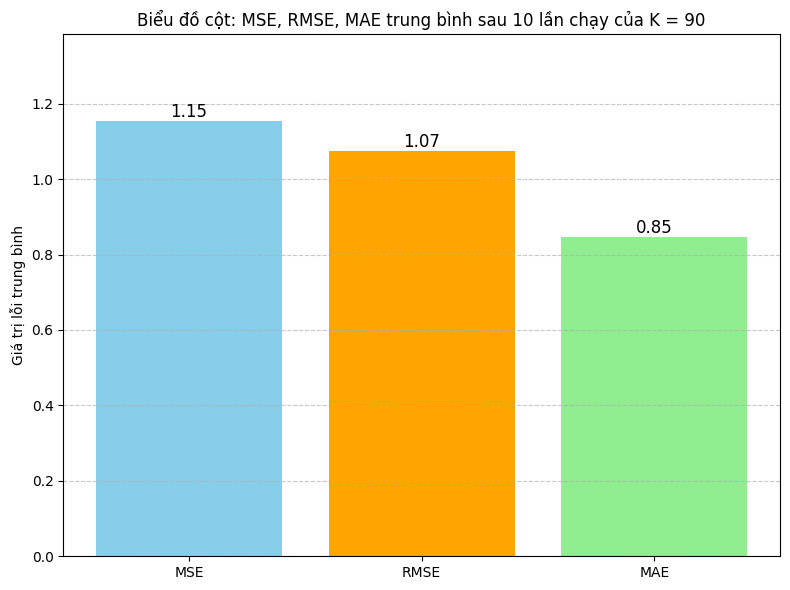

K=90:
Avg Train Time: 1.0717s
Avg Test Time: 0.0000s
Trung binh: RMSE = 1.0733 | MAE = 0.8458 | MSE = 1.1530


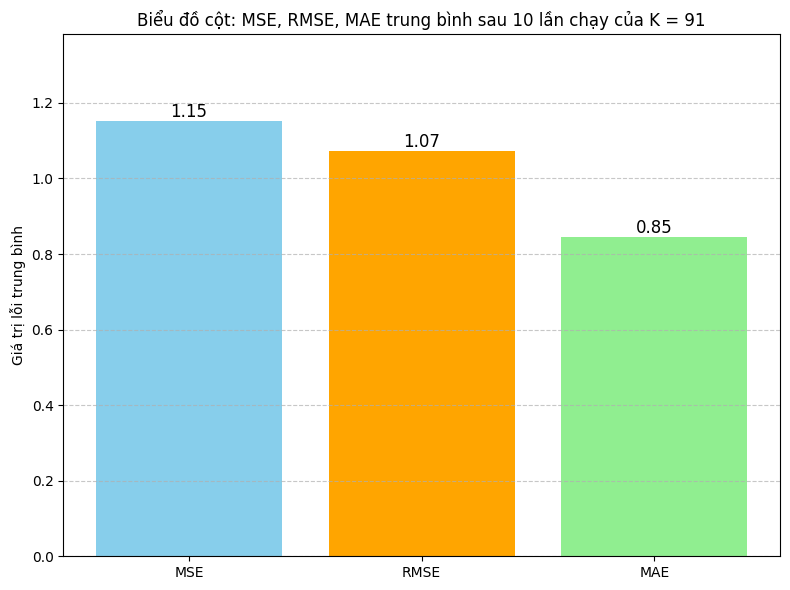

K=91:
Avg Train Time: 3.1094s
Avg Test Time: 0.0001s
Trung binh: RMSE = 1.0725 | MAE = 0.8455 | MSE = 1.1511


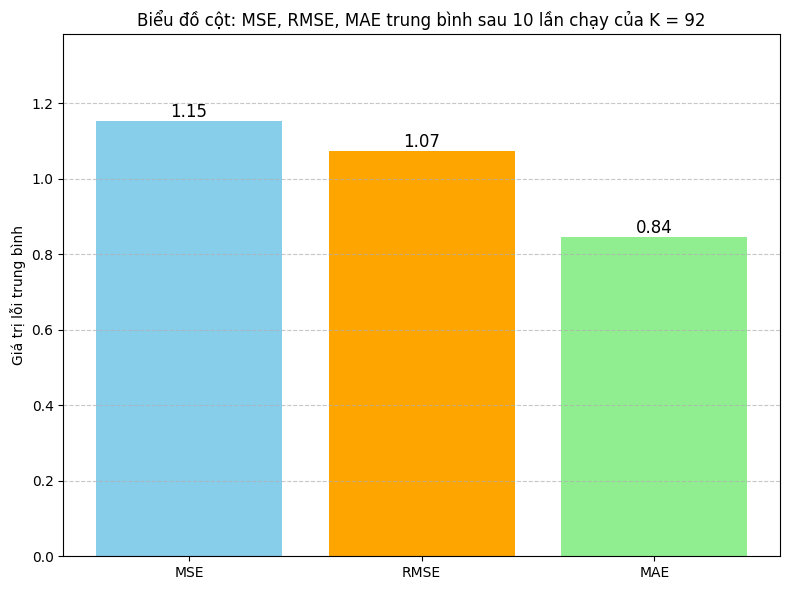

K=92:
Avg Train Time: 4.0400s
Avg Test Time: 0.0000s
Trung binh: RMSE = 1.0729 | MAE = 0.8449 | MSE = 1.1520


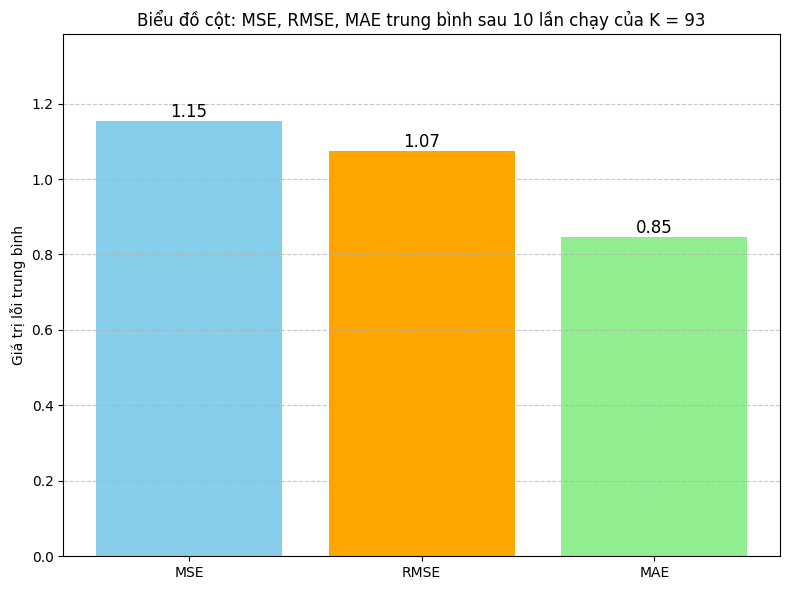

K=93:
Avg Train Time: 5.9836s
Avg Test Time: 0.0001s
Trung binh: RMSE = 1.0732 | MAE = 0.8453 | MSE = 1.1527


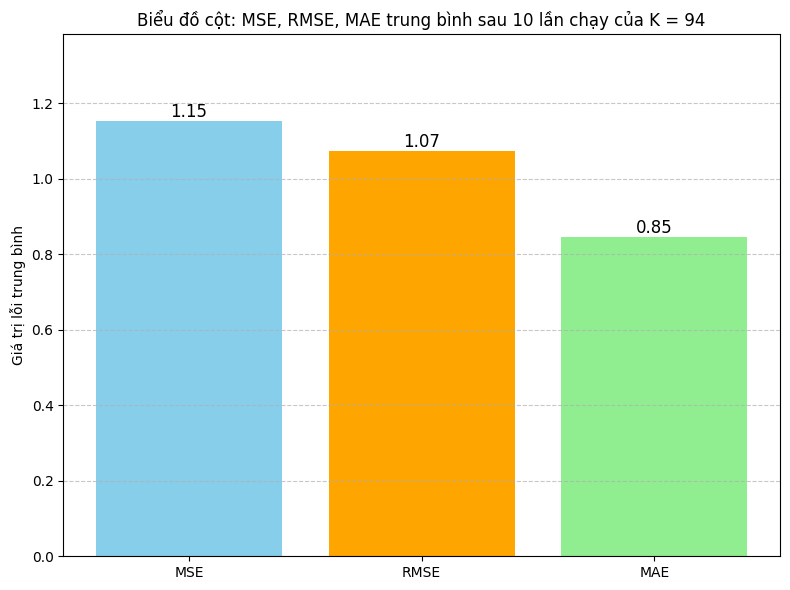

K=94:
Avg Train Time: 7.0408s
Avg Test Time: 0.0003s
Trung binh: RMSE = 1.0727 | MAE = 0.8453 | MSE = 1.1516


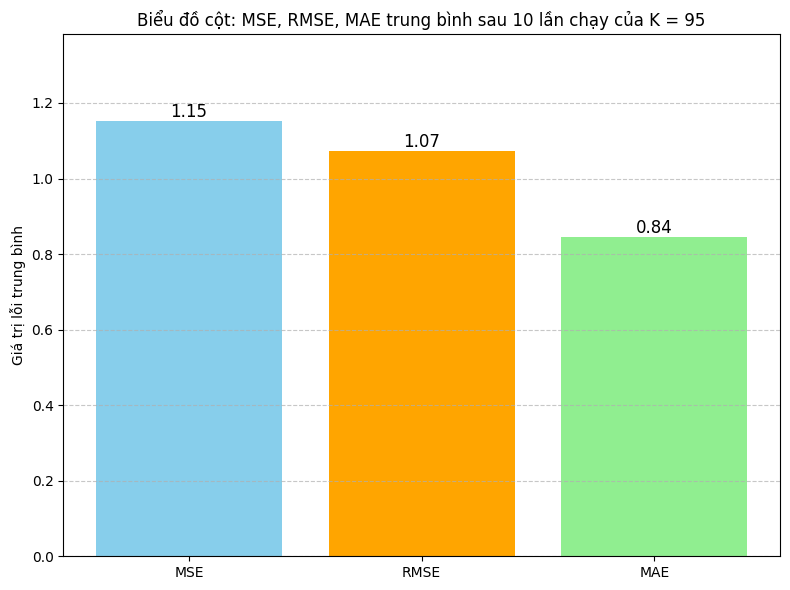

K=95:
Avg Train Time: 1.5966s
Avg Test Time: 0.0000s
Trung binh: RMSE = 1.0726 | MAE = 0.8448 | MSE = 1.1513


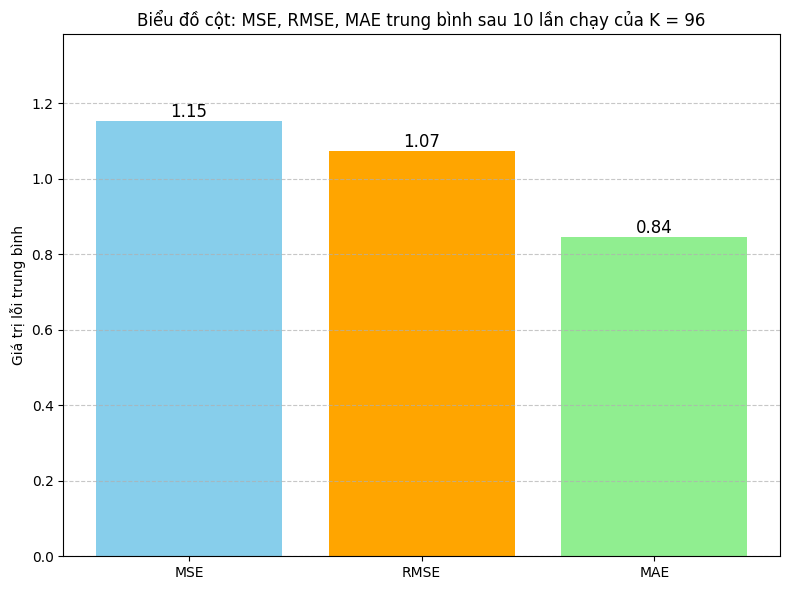

K=96:
Avg Train Time: 2.4915s
Avg Test Time: 0.0000s
Trung binh: RMSE = 1.0729 | MAE = 0.8449 | MSE = 1.1520


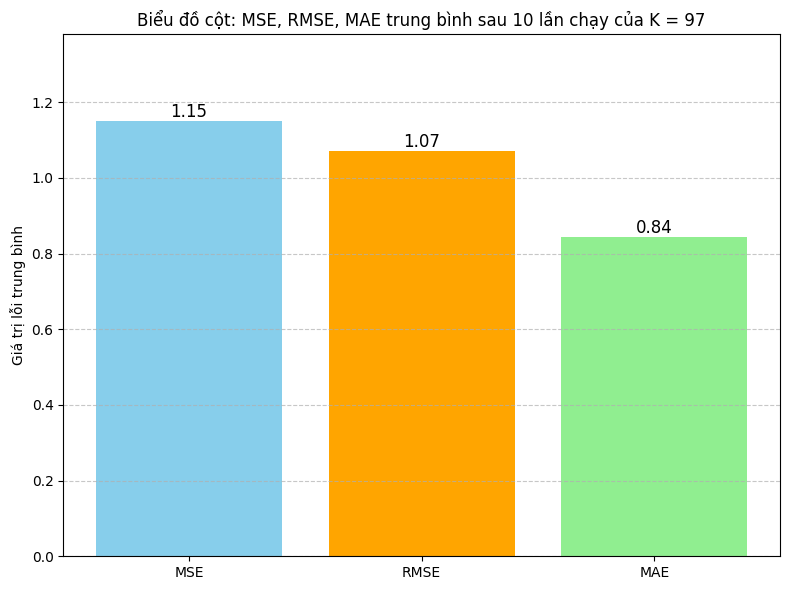

K=97:
Avg Train Time: 3.6640s
Avg Test Time: 0.0000s
Trung binh: RMSE = 1.0718 | MAE = 0.8437 | MSE = 1.1496


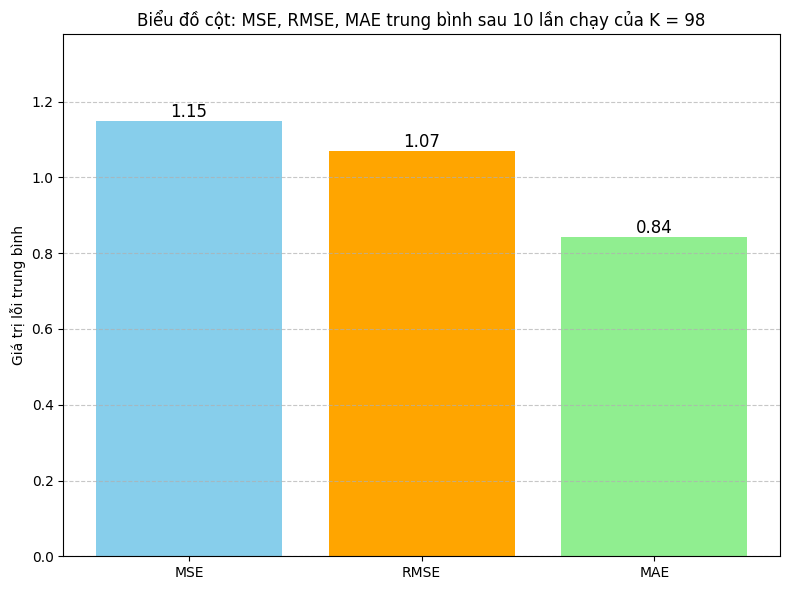

K=98:
Avg Train Time: 2.8953s
Avg Test Time: 0.0000s
Trung binh: RMSE = 1.0710 | MAE = 0.8428 | MSE = 1.1478


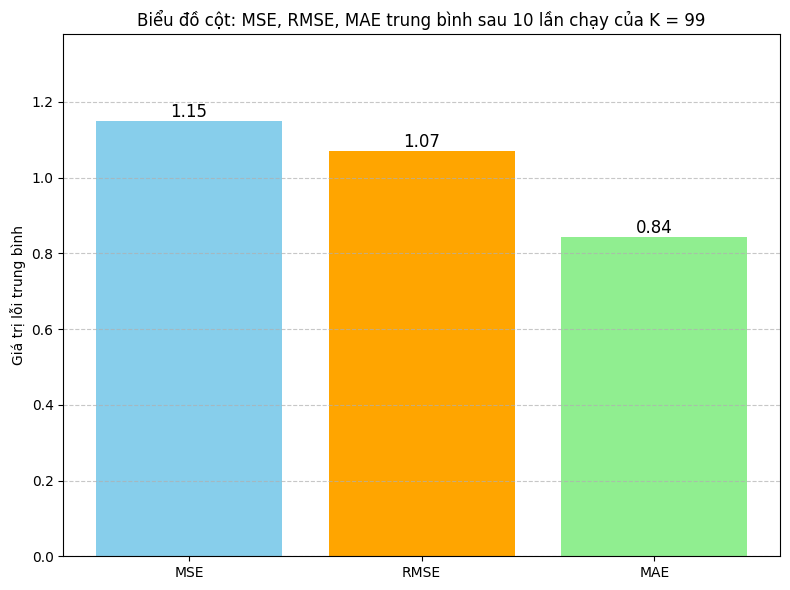

K=99:
Avg Train Time: 1.8495s
Avg Test Time: 0.0000s
Trung binh: RMSE = 1.0712 | MAE = 0.8426 | MSE = 1.1481


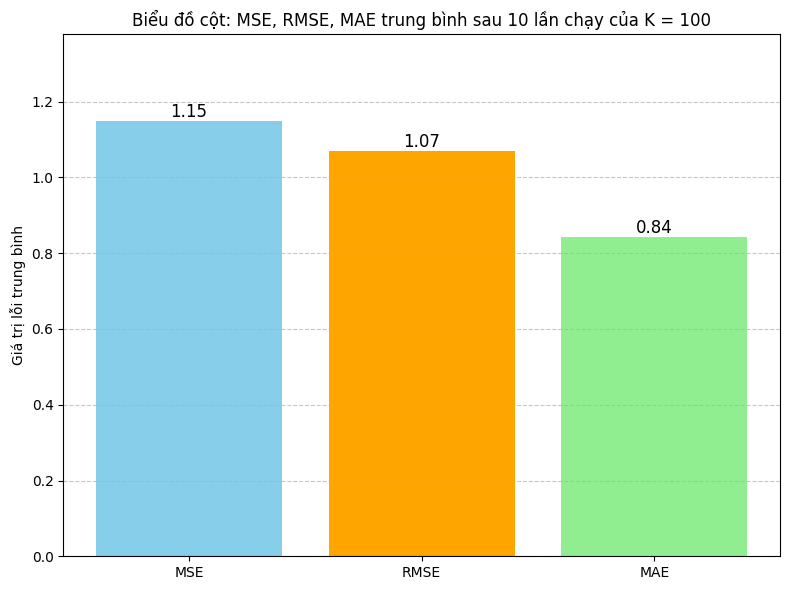

K=100:
Avg Train Time: 2.0314s
Avg Test Time: 0.0000s
Trung binh: RMSE = 1.0711 | MAE = 0.8420 | MSE = 1.1480


In [15]:
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
results = []
for k in range(81, 101):
    train_times = []
    test_times = []
    mse_list = []
    rmse_list = []
    mae_list = []
    for run in range(10):

        # Xáo trộn test_data trước khi tạo sample_test
        shuffled_data = test_data.sample(frac=1, random_state=run).reset_index(drop=True)
        sample_test = shuffled_data.sample(n=1000, random_state=run)

        # Đo thời gian "train"
        start_train = time.time()
        test_subset = sample_test.copy()
        test_subset["predicted_rating"] = test_subset.apply(
            lambda row: predict_rating(row["userId"], row["movieId"], k=k), axis=1
        )
        test_subset = test_subset.dropna(subset=["predicted_rating"])
        train_time = time.time() - start_train
        train_times.append(train_time)

        y_true = test_subset["rating"]

        start_test = time.time()
        y_pred = test_subset["predicted_rating"]
        test_time = time.time() - start_test
        test_times.append(test_time)

        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)

    Ketqua_mse = statistics.mean(mse_list)
    Ketqua_rmse = statistics.mean(rmse_list)
    Ketqua_mae = statistics.mean(mae_list)
    results.append((k, Ketqua_mse, Ketqua_rmse, Ketqua_mae))
    # Vẽ biểu đồ cột
    metrics = ['MSE', 'RMSE', 'MAE']
    values = [Ketqua_mse, Ketqua_rmse, Ketqua_mae]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(metrics, values, color=['skyblue', 'orange', 'lightgreen'])

    # Hiển thị giá trị trên đầu cột
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=12)

    plt.ylabel('Giá trị lỗi trung bình')
    plt.title('Biểu đồ cột: MSE, RMSE, MAE trung bình sau 10 lần chạy của K = '+str(k))
    plt.ylim(0, max(values) * 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Tổng kết trung bình
    print("K="+str(k)+":")
    print(f"Avg Train Time: {np.mean(train_times):.4f}s")
    print(f"Avg Test Time: {np.mean(test_times):.4f}s")
    print(f"Trung binh: RMSE = {Ketqua_rmse:.4f} | MAE = {Ketqua_mae:.4f} | MSE = {Ketqua_mse:.4f}")
    
    # print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
    # print(f"Avg MAE: {np.mean(mae_list):.4f}")
    # print(f"Avg MSE: {np.mean(mse_list):.4f}")
    # print(f"Trung binh: RMSE = {np.mean(rmse_list):.4f} | MAE = {np.mean(mae_list):.4f} | MSE = {np.mean(mse_list):.4f}")


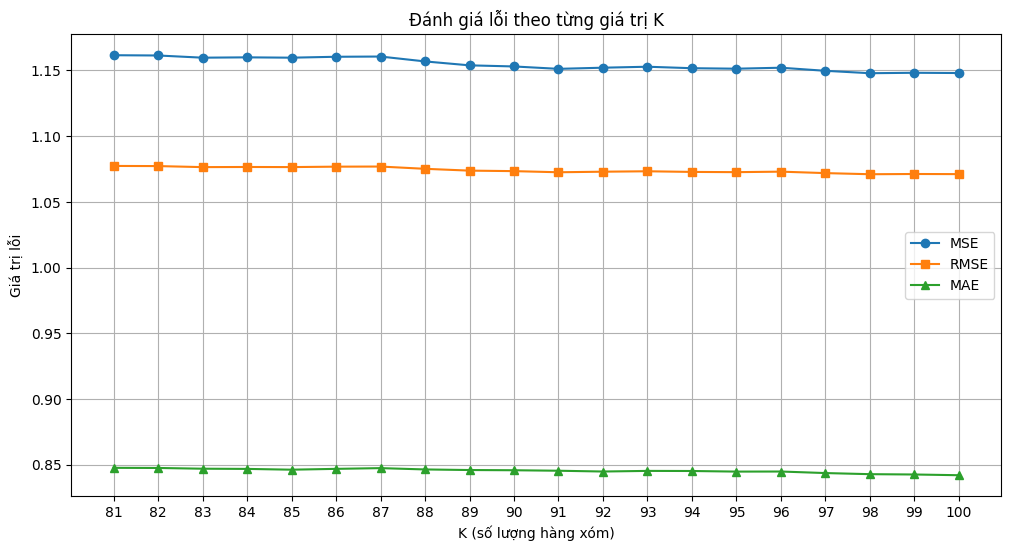

In [16]:
import matplotlib.pyplot as plt

# Tách các giá trị để vẽ biểu đồ
ks = [r[0] for r in results]
mses = [r[1] for r in results]
rmses = [r[2] for r in results]
maes = [r[3] for r in results]

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))

plt.plot(ks, mses, marker='o', label='MSE')
plt.plot(ks, rmses, marker='s', label='RMSE')
plt.plot(ks, maes, marker='^', label='MAE')

plt.title("Đánh giá lỗi theo từng giá trị K")
plt.xlabel("K (số lượng hàng xóm)")
plt.ylabel("Giá trị lỗi")
plt.xticks(ks)
plt.grid(True)
plt.legend()
plt.show()
